In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random

def generate_energy_prices(T, base_price, peak_amplitudes, peak_times, std_dev):
    """
    Generate a realistic daily electricity price trend with two peaks and stochastic variations,
    now enhanced for 15-min intervals.

    Parameters:
        T (int): Number of time steps (e.g., hours).  Now represents 15-min intervals.
        base_price (float): Average electricity price ($/MWh).
        peak_amplitude (float): Amplitude of price fluctuations due to demand.
        peak_times (list): List of peak electricity price hours (e.g., [8, 18] for morning and evening peaks).
        std_dev (float): Standard deviation for stochastic variations.

    Returns:
        np.array: Simulated electricity prices over time.
    """
    time = np.arange(T)
    hours = time / 4.0  # Convert 15-min intervals to hours for the sinusoidal function

    # Sum of two sinusoidal functions for morning and evening peaks
    prices = (base_price
              + peak_amplitudes[0] * -np.sin((hours - peak_times[0]) * np.pi / 6)
              + peak_amplitudes[1] * -np.sin((hours - peak_times[1]) * np.pi / 12))

    # Add stochastic noise, scaled down for 15-min intervals
    prices += np.random.normal(0, std_dev/2, T) # Reduced standard deviation.  The original std_dev was on an hourly basis.  We're now on a 15-min basis, so the noise should be smaller.
    prices = np.clip(prices, 0, None)
    return prices

def stochastic_basin_inflow(T, base_inflow, base_std, avg_extra,rain_prob, extra_std):
    """
    Generate stochastic basin inflows over a given time horizon.

    Parameters:
        T (int): Number of time steps.
        base_inflow (float): Average base inflow (MWh per time step).
        base_std (float): Standard deviation for the base inflow.
        avg_extra (float): Average extra inflow due to rainfall.
        rain_prob (float): Probability of extra rainfall inflow.
        extra_std (float): Standard deviation for the extra inflow from rainfall.

    Returns:
        np.array: Stochastic basin inflow series (MWh per time step).
    """
    base = np.random.normal(base_inflow, base_std, T)
    base = np.clip(base, 0, None)
    rain_events = np.random.binomial(1, rain_prob, T)
    extra = rain_events * np.random.normal(avg_extra, extra_std, T)
    extra = np.clip(extra, 0, None)
    return base + extra

def evaporation_loss(T, avg_evap, peak_time, peak_amplitude):
    """
    Generate an approximation of evaporation loss.

    Parameters:
        T (int): Number of time steps.
        avg_evap (float): Average daily evaporation loss per hour (MWh).
        peak_time (int): Time of maximum evaporation.
        peak_amplitude (float): Additional evaporation at peak.

    Returns:
        np.array: Hourly evaporation loss.
    """
    time = np.arange(T)
    hours = time / 4.0
    evap = avg_evap + peak_amplitude * np.sin((np.pi / 12) * (hours + peak_time + 2*np.pi ))
    evap = np.clip(evap, 0, None)
    return evap

In [17]:
# --- Main Part of the Code ---
# Time horizon
T = 24 * 4  # 24 hours * 4 intervals/hour = 96 intervals

# System parameters
reservoir_capacity = 1000
initial_storage = 600
S_min = 100
pump_max = 100 / 4  # changed to 15 min
gen_max = 100 / 4  # changed to 15 min

# --- Ramping Constraints ---
ramp_rate_pump_15min = 50 / 4
ramp_rate_gen_15min = 60 / 4


# --- Define Variable Efficiency Functions ---
def pump_efficiency_func(p):
    """Example: Efficiency decreases as pumping power increases."""
    return 0.8 - 0.1 * (p / pump_max)


def gen_efficiency_func(g):
    """Example: Efficiency increases as generation power increases."""
    return 0.75 + 0.15 * (g / gen_max)

# --- Vectorized compute_storage function ---
def compute_storage(z, initial_storage, inflows):
    """
    Compute storage trajectory based on pumping and generation decisions, vectorized.

    Parameters:
        z (np.array): Decision variables [pumping, generation].
        initial_storage (float): Initial storage level.
        inflows (np.array): Inflows at each time step.

    Returns:
        np.array: Storage levels at each time step.
    """
    p = z[:T]
    g = z[T:2 * T]

    # Calculate efficiencies for all time steps at once
    pump_efficiencies = pump_efficiency_func(p)
    gen_efficiencies = gen_efficiency_func(g)

    # Vectorized storage calculation
    storage_levels = np.zeros(T + 1)
    storage_levels[0] = initial_storage
    storage_levels[1:] = initial_storage + np.cumsum(pump_efficiencies * p - gen_efficiencies * g + inflows)

    return storage_levels

# --- Objective Function ---
def objective(z, prices):
    """Calculate the negative profit, now with prices."""
    p = z[:T]
    g = z[T:2 * T]
    return -np.sum(prices * (g - p))

# --- Constraints ---
def constraints_function(initial_storage, reservoir_capacity, S_min, T):
    """
    Define the constraints for the optimization problem.

    Parameters:
        initial_storage (float): Initial storage level.
        reservoir_capacity (float): Maximum storage level.
        S_min (float): Minimum storage level.
        T (int): Number of time steps.

    Returns:
        function: A function that calculates the constraints.
    """
    def constraints(z, prices, inflows):  # added prices and inflows
        S = compute_storage(z, initial_storage, inflows)
        p = z[:T]
        g = z[T:2 * T]
        con = []
        for t in range(1, T + 1):
            con.extend([S[t] - S_min, reservoir_capacity - S[t]])

        # Ramping Constraints
        for t in range(T - 1):
            con.extend([ramp_rate_pump_15min - (p[t + 1] - p[t]), ramp_rate_pump_15min - (p[t] - p[t + 1])])
            con.extend([ramp_rate_gen_15min - (g[t + 1] - g[t]), ramp_rate_gen_15min - (g[t] - g[t + 1])])

        # No simultaneous pumping and generation
        for t in range(T):
            con.append(p[t] + g[t] <= max(pump_max, gen_max))  # Either p or g must be 0, changed from 0 to max

        con.append(S[-1] - initial_storage)
        return con

    return constraints

# --- Main Optimization Function ---
def optimize_storage(prices, inflows, initial_storage, reservoir_capacity, S_min,
                     pump_max, gen_max, T):
    """
    Optimize the pumped hydro storage operation.

    Parameters:
        prices (np.array): Electricity prices.
        inflows (np.array): Water inflows.
        initial_storage (float): Initial storage level.
        reservoir_capacity (float): Maximum storage.
        S_min (float): Minimum storage.
        pump_max (float): Max pumping power.
        gen_max (float): Max generation power.
        T (int): Time horizon.

    Returns:
        optimize.OptimizeResult: Optimization result.
    """
    if not isinstance(prices, np.ndarray) or not isinstance(inflows, np.ndarray):
        raise TypeError("prices and inflows must be numpy arrays.")
    if prices.shape != (T,) or inflows.shape != (T,):
        raise ValueError(f"prices and inflows must have shape ({T},).")
    if not all(isinstance(x, (int, float)) for x in
                   [initial_storage, reservoir_capacity, S_min, pump_max, gen_max]) or \
            any(x < 0 for x in [initial_storage, reservoir_capacity, S_min, pump_max, gen_max]):
        raise ValueError(
            "initial_storage, reservoir_capacity, S_min, pump_max, and gen_max must be non-negative numbers.")
    if not isinstance(T, int) or T <= 0:
        raise ValueError("T must be a positive integer.")
    if S_min > reservoir_capacity:
        raise ValueError("S_min cannot be greater than reservoir_capacity.")
    if pump_max > reservoir_capacity or gen_max > reservoir_capacity:
        raise ValueError("pump_max and gen_max cannot be greater than reservoir_capacity")


    # Bounds for decision variables
    bounds = [(0, pump_max)] * T + [(0, gen_max)] * T
    # Initial guess
    z0 = np.zeros(2 * T)
    # Constraints
    constraints = {
        'type': 'ineq',
        'fun': constraints_function(initial_storage, reservoir_capacity, S_min, T),
        'args': (prices, inflows)  # Pass prices and inflows to the constraints function
    }
    # Objective function with prices as an argument
    objective_with_prices = lambda z: objective(z, prices)

    try:
        result = minimize(objective_with_prices, z0, method='SLSQP', bounds=bounds,
                            constraints=constraints, options={'maxiter': 1000})  # Increased maxiter
        return result
    except Exception as e:
        print(f"An error occurred during optimization: {e}")
        return None

Optimization converged.
Total Daily Profit: € 52491.24


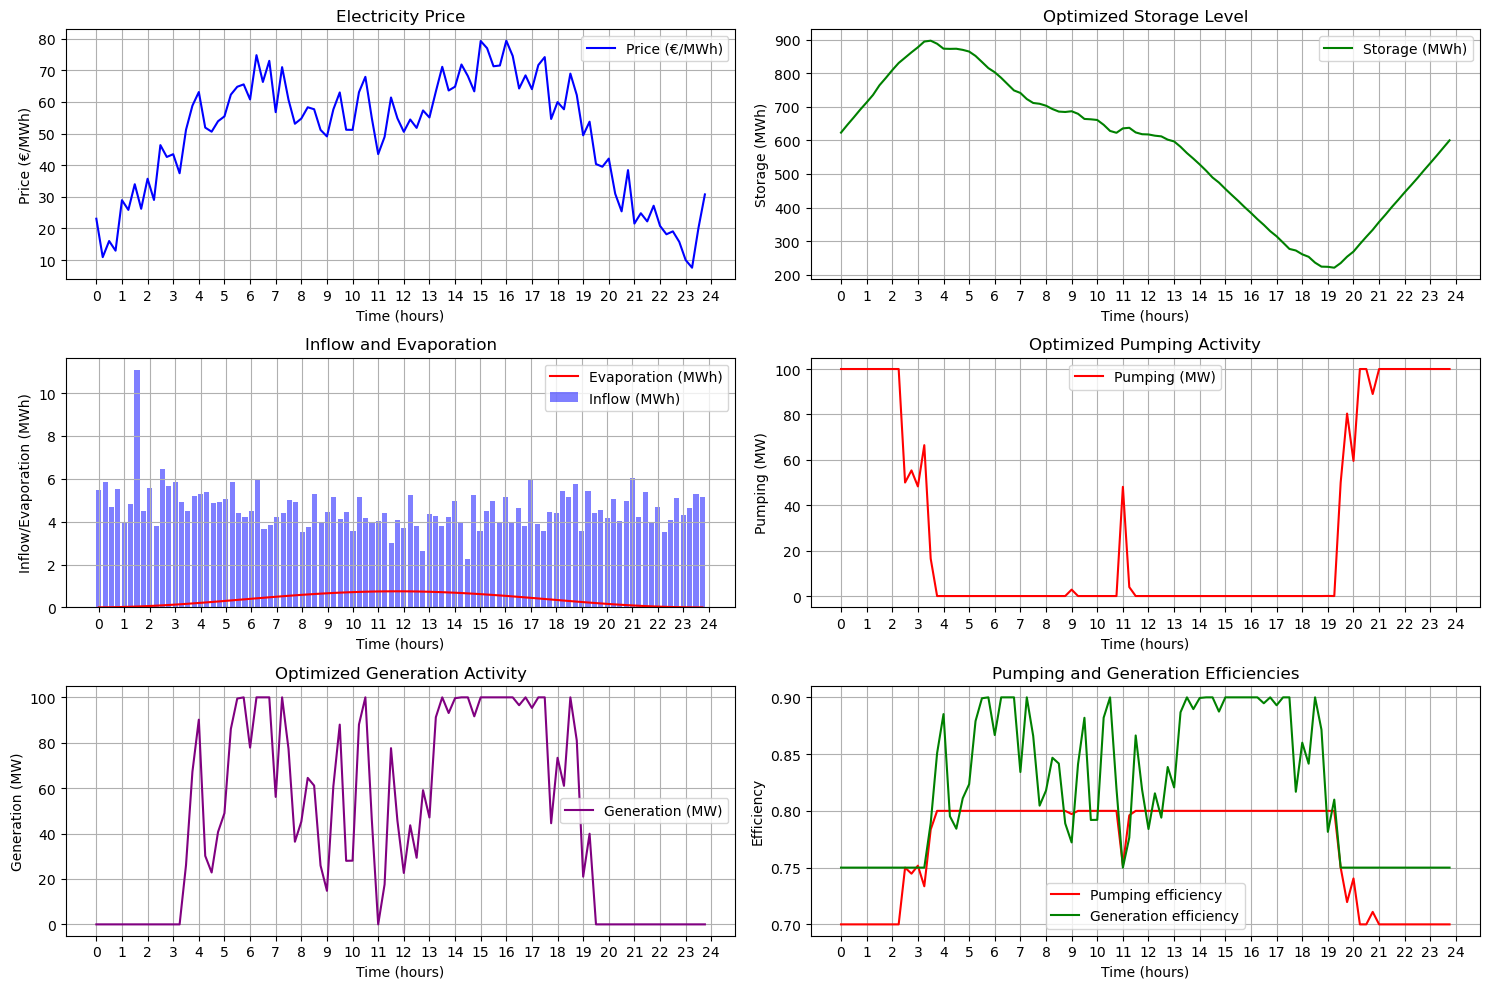

In [19]:
if __name__ == "__main__":
    # --- Generate Data ---
    T = 24 * 4
    prices = generate_energy_prices(T, base_price=50, peak_amplitudes=[15, 20],
                                    peak_times=[8, 18], std_dev=10)  # Increased std_dev for robustness testing
    evaporation = evaporation_loss(T, avg_evap=1.5 / 4, peak_time=12, peak_amplitude=1.5 / 4)
    inflows = stochastic_basin_inflow(T, base_inflow=20 / 4, base_std=3 / 4,
                                        avg_extra=20 / 4, rain_prob=0.03 / 4,
                                        extra_std=5 / 4) - evaporation

    # --- Optimization ---
    result = optimize_storage(prices, inflows, initial_storage, reservoir_capacity,
                              S_min, pump_max, gen_max, T)


    if result and result.success:  # check if result is not None
        z_opt = result.x
        p_opt = z_opt[:T]
        g_opt = z_opt[T:2 * T]
        S_opt = compute_storage(z_opt, initial_storage, inflows)
        total_profit = -objective(z_opt, prices)  # pass prices
        print("Optimization converged.")
        print("Total Daily Profit: €", round(total_profit, 2))

        # --- Plotting ---
        time_15min = np.arange(T)  # Time axis for 15-min intervals

        pump_efficiencies = [pump_efficiency_func(p_val) for p_val in p_opt]
        gen_efficiencies = [gen_efficiency_func(g_val) for g_val in g_opt]


        plt.figure(figsize=(15, 10))

        # Plot price series
        plt.subplot(3, 2, 1)
        plt.plot(time_15min, prices, label="Price (€/MWh)", color='b', linestyle='-')
        plt.xlabel("Time (hours)")
        plt.ylabel("Price (€/MWh)")
        plt.title("Electricity Price")
        plt.grid(True)
        plt.legend()
        plt.xticks(np.arange(0, T + 1, 4), np.arange(0, 25))

        # Plot optimized storage levels
        plt.subplot(3, 2, 2)
        plt.plot(time_15min, S_opt[1:], label="Storage (MWh)", color='g', linestyle='-')  # Adjusted S_opt
        plt.xlabel("Time (hours)")
        plt.ylabel("Storage (MWh)")
        plt.title("Optimized Storage Level")
        plt.grid(True)
        plt.legend()
        plt.xticks(np.arange(0, T + 1, 4), np.arange(0, 25))

        # Plot Inflow and Evaporation
        plt.subplot(3, 2, 3)
        plt.plot(time_15min, evaporation, label="Evaporation (MWh)", color='r', linestyle='-')
        plt.bar(time_15min, inflows, label="Inflow (MWh)", color='blue', alpha=0.5)
        plt.xlabel("Time (hours)")
        plt.ylabel("Inflow/Evaporation (MWh)")
        plt.title("Inflow and Evaporation")
        plt.grid(True)
        plt.legend()
        plt.xticks(np.arange(0, T + 1, 4), np.arange(0, 25))

        # Plot optimized pumping decisions
        plt.subplot(3, 2, 4)
        plt.plot(time_15min, p_opt*4, label="Pumping (MW)", color='r')
        plt.xlabel("Time (hours)")
        plt.ylabel("Pumping (MW)")
        plt.title("Optimized Pumping Activity")
        plt.grid(True)
        plt.legend()
        plt.xticks(np.arange(0, T + 1, 4), np.arange(0, 25))

        # Plot optimized generation decisions
        plt.subplot(3, 2, 5)
        plt.plot(time_15min, g_opt*4, label="Generation (MW)", color='purple')
        plt.xlabel("Time (hours)")
        plt.ylabel("Generation (MW)")
        plt.title("Optimized Generation Activity")
        plt.grid(True)
        plt.legend()
        plt.xticks(np.arange(0, T + 1, 4), np.arange(0, 25))

        # Plot efficiencies
        plt.subplot(3, 2, 6)
        plt.plot(time_15min, pump_efficiencies, label="Pumping efficiency", color='r')
        plt.plot(time_15min, gen_efficiencies, label="Generation efficiency", color='g')
        plt.xlabel("Time (hours)")
        plt.ylabel("Efficiency")
        plt.title("Pumping and Generation Efficiencies")
        plt.grid(True)
        plt.legend()
        plt.xticks(np.arange(0, T + 1, 4), np.arange(0, 25))

        
        plt.tight_layout()
        plt.show()

    else:
        print("Optimization did not converge or error occurred.")